## Conformalized Survival Analysis with Right-Censoring

This notebook demonstrates the performance of DR-COSARC, a method to calibrate lower confidence bounds for survival times under right-censoring.
This method used imputation of unobserved censoring times to obtain an artificial data set with type-I censoring, and then applies Candes' method.
The methods are implemented in the accompanying "utils" R scripts.

In [1]:
# Load required libraries
suppressMessages(library(tidyverse))
suppressMessages(library(gridExtra))
library(survival)
library(ggsurvfit)
library(grf)
library(cfsurvival)

## Generate a synthetic survival data set

We focus on the three setting described in the paper.

In [2]:
source("../conf_surv/utils_data.R")

## Remove censoring 
## Set this flag to 'TRUE' to effectively remove censoring from the data (by making the censoring times very large)
data_without_censoring = FALSE

## Definitions of Settings 1--3 from the paper (in decreasing order of intrinsic difficulty)
setting = 3

if(setting==1) {
    ## New setting (difficult)
    ## Initialize the covariate model
    num_features <- 100
    covariate_generator <- function(num_samples) {
        matrix(runif(num_samples * num_features, 0, 1), nrow = num_samples)
    }
    ## Initialize the survival time distribution
    surv_mu_fun <- function(X) 0*X[,1] + (X[,2]>0.5) + (X[,3]<0.5) + (1-X[,1])^0.25
    surv_sigma_fun <- function(X) 0*X[,1] + 0.1 * (1-X[,1])
    survival_generator <- LogNormalDistribution$new(mu_fun = surv_mu_fun, sigma_fun = surv_sigma_fun)
    ## Initialize the censoring time distribution
    cens_mu_fun <- function(X) 0*X[,1] + (X[,2]>0.5) + (X[,3]<0.5) + (1-X[,1])^4 + 0.4
    cens_sigma_fun <- function(X) 0*X[,1] + 0.1 * X[,2]
    if(data_without_censoring) {
        cens_mu_fun <- function(X) 0*X[,1] + 1e-9
    }
    censoring_generator <- LogNormalDistribution$new(mu_fun = cens_mu_fun, sigma_fun = cens_sigma_fun)
    
} else if(setting==2) {
    ## New setting (medium)
    ## Initialize the covariate model
    num_features <- 100
    covariate_generator <- function(num_samples) {
        matrix(runif(num_samples * num_features, 0, 1), nrow = num_samples)
    }
    ## Initialize the survival time distribution
    surv_mu_fun <- function(X) 0*X[,1] + X[,1]^0.25
    surv_sigma_fun <- function(X) 0*X[,1] + 0.1
    survival_generator <- LogNormalDistribution$new(mu_fun = surv_mu_fun, sigma_fun = surv_sigma_fun)
    ## Initialize the censoring time distribution
    cens_mu_fun <- function(X) 0*X[,1] + X[,1]^4 + 0.4
    cens_sigma_fun <- function(X) 0*X[,1] + 0.1
    if(data_without_censoring) {
        cens_mu_fun <- function(X) 0*X[,1] + 2
    }
    censoring_generator <- LogNormalDistribution$new(mu_fun = cens_mu_fun, sigma_fun = cens_sigma_fun)

} else if(setting==3) {
    ## Setting 4 from Candes et al. (easy)
    ## Initialize the covariate model
    num_features <- 100
    covariate_generator <- function(num_samples) {
        matrix(runif(num_samples * num_features, -1, 1), nrow = num_samples)
    }
    ## Initialize the survival time distribution
    surv_mu_fun <- function(X) 0*X[,1] + log(2) + 1 + 0.55*(X[,1]^2-X[,3]*X[,5])
    surv_sigma_fun <- function(X) 0*X[,1] + abs(X[,10]) + 1
    survival_generator <- LogNormalDistribution$new(mu_fun = surv_mu_fun, sigma_fun = surv_sigma_fun)
    ## Initialize the censoring time distribution
    cens_rate_fun <- function(X) 0*X[,1] + 0.4
    if(data_without_censoring) {
        cens_rate_fun <- function(X) 0*X[,1] + 1e-9
    }
    censoring_generator <- ExponentialDistribution$new(rate_fun = cens_rate_fun)

} else if(setting==4) {
    ## More interesting
    ## Initialize the covariate model
    num_features <- 100
    covariate_generator <- function(num_samples) {
        X <- matrix(runif(num_samples * num_features, -1, 1), nrow = num_samples)
        idx.shift <- sample(1:nrow(X), nrow(X)/2)
        X[idx.shift,3] <- X[idx.shift,3] + 20
        X[idx.shift,5] <- abs(X[idx.shift,5])
        return(X)
    }
    ## Initialize the survival time distribution
    surv_mu_fun <- function(X) 0*X[,1] + log(2) + 1 + 0.55*(X[,1]^2-X[,3]*X[,5])
    surv_sigma_fun <- function(X) 0*X[,1] + abs(X[,10]) + 1
    survival_generator <- LogNormalDistribution$new(mu_fun = surv_mu_fun, sigma_fun = surv_sigma_fun)
    ## Initialize the censoring time distribution
    cens_rate_fun <- function(X) 0*X[,1] + 0.4
    if(data_without_censoring) {
        cens_rate_fun <- function(X) 0*X[,1] + 1e-9
    }
    censoring_generator <- ExponentialDistribution$new(rate_fun = cens_rate_fun)
}
    
# Initialize the data generator
generator <- SurvivalDataGenerator$new(covariate_generator, survival_generator, censoring_generator)

Let us now generate independent training, calibration, and test sets, from the distribution defined above.

First we generate full survival data, including (X, T, C), and then we extract the relevant variables under a right-censoring framewor, namely (X, min(T,C), I(T<C)).

In [3]:
# Sample sizes
num_samples_train <- 1000
num_samples_cal <- 1000
num_samples_test <- 1000

# Set random seet
set.seed(2024)

# Generate training, calibration, and test data
# (including true event and censoring times)
data.train.oracle <- generator$sample(num_samples_train)
data.cal.oracle <- generator$sample(num_samples_cal)
data.test.oracle <- generator$sample(num_samples_test)

# Remove true event and censoring times from the data (right-censoring)
data.train <- data.train.oracle |> select(-event_time, -censoring_time)
data.cal <- data.cal.oracle |> select(-event_time, -censoring_time)
data.test <- data.test.oracle |> select(-event_time, -censoring_time)

# Remove only true event times from the data (type-I censoring)
data.train.t1 <- data.train.oracle |> select(-event_time)
data.cal.t1 <- data.cal.oracle |> select(-event_time)
data.test.t1 <- data.test.oracle |> select(-event_time)

## Explore the data (using oracle knowledge)

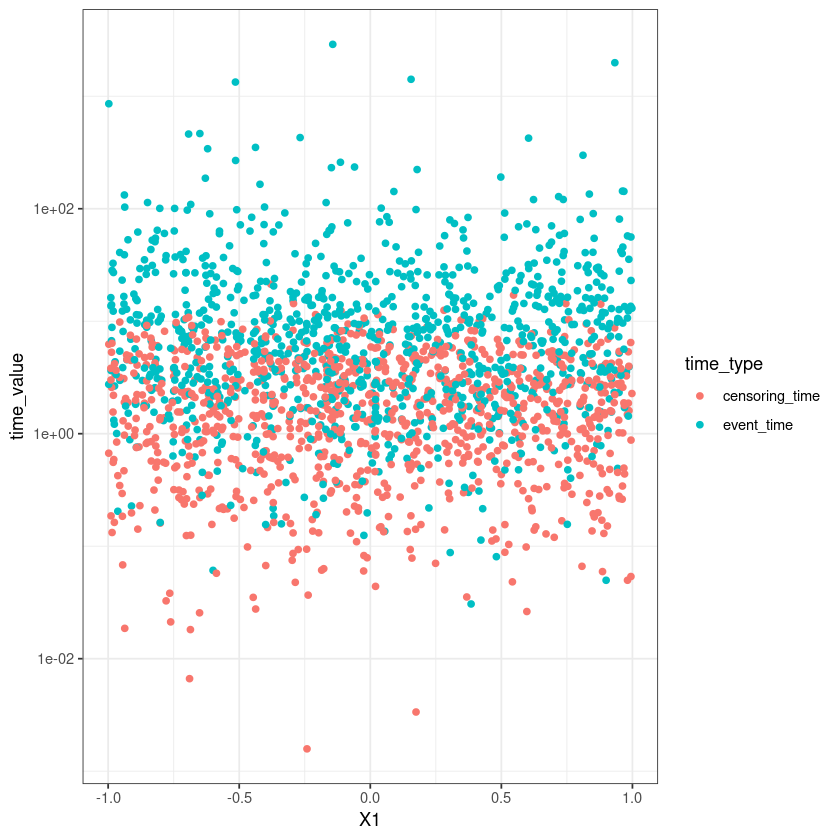

In [4]:
data.test.oracle |>
    select(X1, event_time, censoring_time) |>
    pivot_longer(cols = c(event_time, censoring_time), 
                 names_to = "time_type", values_to = "time_value") |>
    ggplot(aes(x=X1, y=time_value, color=time_type)) +
    geom_point() +
    scale_y_continuous(trans='log10') +
    theme_bw()

Suppose we know the true (oracle) data distribution. Then, we can compute the "ideal" oracle lower prediction bounds for the survival time, and evaluate them.
This will serve as an ideal benchmark for all methods.

In [5]:
source("../conf_surv/utils_conformal.R")

alpha = 0.1

pred.oracle.fast <- generator$survival$predict_quantiles(select(data.test, -time, -status), probs=c(alpha))[[1]]

evaluate_bounds(data.test$time, 
                pred.oracle.fast,
                event_time=data.test.oracle$event_time)

Mean lower bound,Coverage (event time),Coverage (lower bound),Coverage (upper bound)
<dbl>,<dbl>,<dbl>,<lgl>
1.058271,0.902,0.565,NA


## Explore the data (practically)

Let's take a look at the data that we would normally see under type-I censoring. We focus on the training data here.

In [6]:
# Summarize data under type-I censoring
data.train.oracle |>
    summarise(Observations=n(), Events = sum(status), 
              `Proportion censored`=mean(status==0),
              `Median event time`=median(event_time),
              `Mean event time`=mean(event_time),
              `Median censoring time`=median(censoring_time),
              `Mean censoring time`=mean(censoring_time),
              `Median observed time`=median(time),
              `Median observed event time`=median(time[status]),
              `Median censoring time` = median(censoring_time))

Observations,Events,Proportion censored,Median event time,Mean event time,Median censoring time,Mean censoring time,Median observed time,Median observed event time
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1000,226,0.774,6.599539,27.7737,1.783741,2.595469,1.393415,1.283038


We can also plot the Kaplan-Meier curve

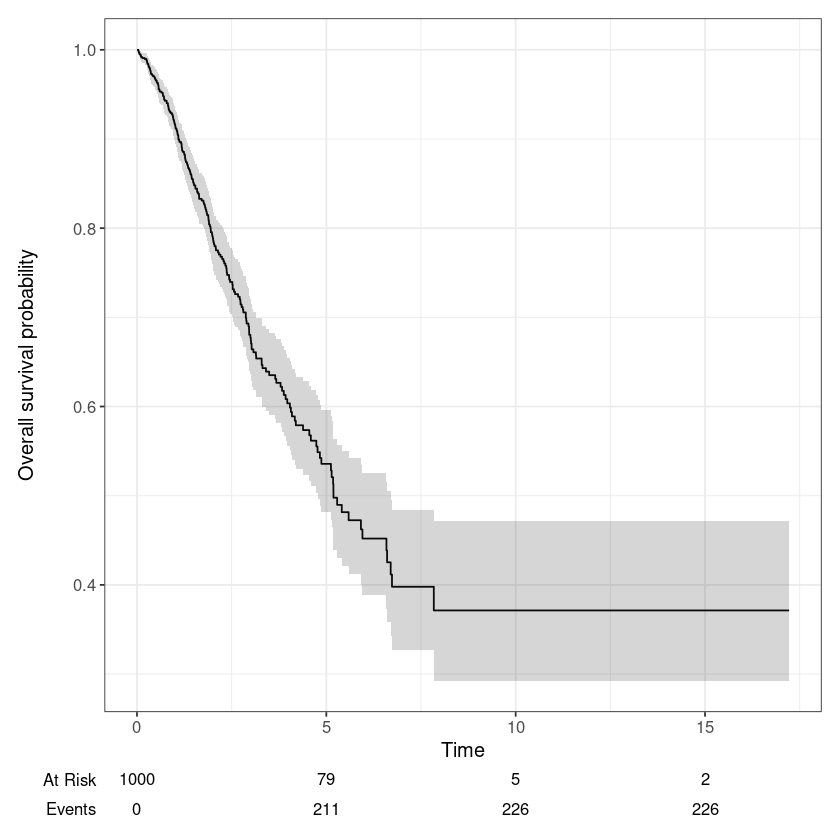

In [7]:
survfit2(Surv(time, status) ~ 1, data = data.train) |> 
  ggsurvfit() +
  labs(
    x = "Time",
    y = "Overall survival probability"
  ) +
  add_confidence_interval() +
  add_risktable()

## Training (survival model)

Fit a survival model using the training data.

In [8]:
source("../conf_surv/utils_survival.R")

model_type = "grf"

if(model_type=="grf") {
    # Instantiate GRF survival forest
    surv_model <- GRF_SurvivalForestWrapper$new()
} else if (model_type=="survreg") {
    # Instantiate Cox proportional hazards model
    surv_model <- SurvregModelWrapper$new(dist="lognormal")
} else if (model_type=="rf") {
    # Instantiate random forest survival model
    surv_model <- randomForestSRC_SurvivalWrapper$new()
} else if (model_type=="cox") {
    # Instantiate random forest survival model
    surv_model <- CoxphModelWrapper$new()
} else {
    stop("Unknown model type!")
}

surv_model$fit(Surv(time, status) ~ ., data = data.train)

Let us now visualize the predicted survival curves for two individuals.

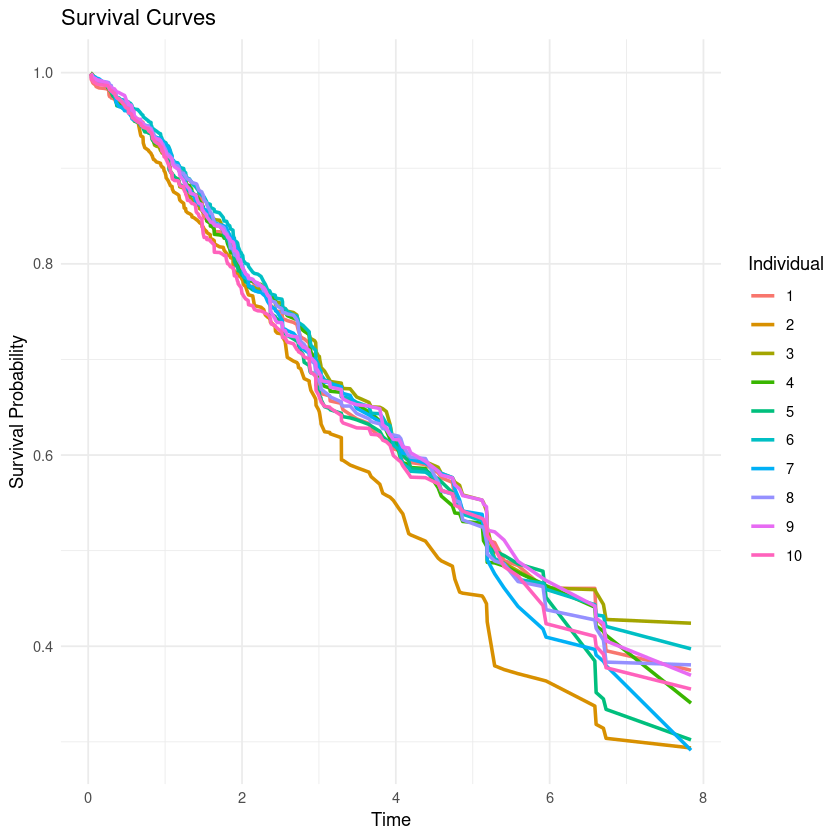

In [9]:
source("../conf_surv/utils_plotting.R")

idx.predict <- c(1:10)
predictions = surv_model$predict(data.cal[idx.predict,])
plot_survival_curves(predictions)

Predict survival time quantiles

In [11]:
# Predict survival time quantiles
surv_model$predict_quantiles(data.cal[idx.predict,], probs = c(0.1, 0.5, 0.9))

,Q10%,Q50%,Q90%
,<dbl>,<dbl>,<dbl>
Individual_1,1.1804657,5.407729,7.83791
Individual_2,0.9872542,4.549886,7.83791
Individual_3,1.0671863,5.285106,7.83791
Individual_4,1.1756982,5.187917,7.83791
Individual_5,1.0516811,5.285106,7.83791
Individual_6,1.2411863,5.285106,7.83791
Individual_7,1.1876392,5.187917,7.83791
Individual_8,1.1808955,5.187917,7.83791
Individual_9,1.1648675,5.588633,7.83791


## Training (censoring model)

Let's start by visualizing the true censoring distribution

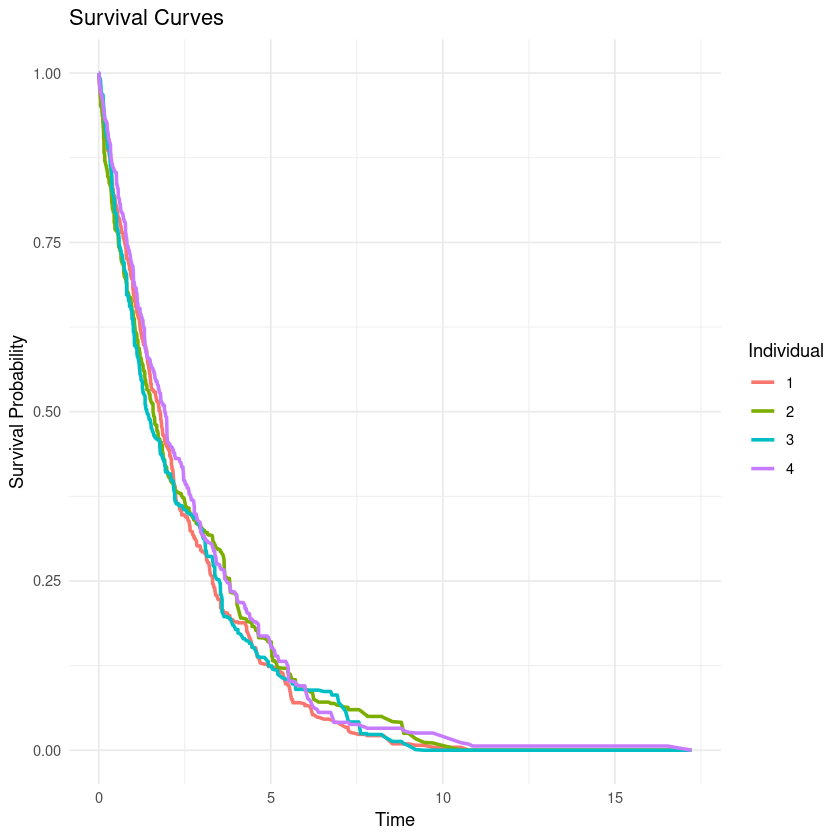

In [12]:
source("../conf_surv/utils_censoring.R")

# List of covariates to use for censoring model
# If we have prior information that some covariates are useless, we can drop them. This helps avoid overfitting, improving the performance of our DR-COSARC.
num_feat_censor <- 10
use.covariates <- paste("X",1:min(num_features,num_feat_censor),sep="")

# Initialize a base model for the censoring distribution
cens_base_model <- GRF_SurvivalForestWrapper$new(use_covariates=use.covariates)
#cens_base_model <- SurvregModelWrapper$new(dist="lognormal", use_covariates=use.covariates)
#cens_base_model <- CoxphModelWrapper$new(use_covariates=use.covariates)
#cens_base_model <- randomForestSRC_SurvivalWrapper$new(use_covariates=use.covariates)

# Create an instance of the CensoringModel class with the model
cens_model <- CensoringModel$new(model = cens_base_model)

# Fit the censoring distribution
cens_model$fit(data = data.train)

# Plot the censoring distribution for the first individual
idx.predict <- c(1:4)
pred_surv = cens_model$model$predict(data.cal[idx.predict,])

plot_survival_curves(pred_surv)

## Constructing lower prediction bounds with different methods

In [13]:
# Oracle prediction bounds
pred.oracle <- generator$survival$predict_quantiles(select(data.test, -time, -status), probs=c(alpha))[[1]]

evaluate_bounds(data.test$time, 
                pred.oracle,
                event_time=data.test.oracle$event_time,
                oracle = pred.oracle,
                method="Oracle")

Method,Mean lower bound,Coverage (event time),Coverage (lower bound),Coverage (upper bound)
<chr>,<dbl>,<dbl>,<dbl>,<lgl>
Oracle,1.058271,0.902,0.565,NA


In [14]:
# No calibration (trust the survival model's output)
pred.uncalibrated <- surv_model$predict_quantiles(data.test, probs=alpha)[[1]]

evaluate_bounds(data.test$time, 
                pred.uncalibrated,
                event_time=data.test.oracle$event_time,
                oracle=pred.oracle,
                method="None")

Method,Mean lower bound,Coverage (event time),Coverage (lower bound),Coverage (upper bound)
<chr>,<dbl>,<dbl>,<dbl>,<lgl>
None,1.130875,0.891,0.545,NA


In [15]:
# Naive CQR
pred.cqr <- predict_CQR(data.test, surv_model, data.cal, alpha)

evaluate_bounds(data.test$time, 
                pred.cqr,
                event_time=data.test.oracle$event_time,
                oracle=pred.oracle,
                method="Naive CQR")

Method,Mean lower bound,Coverage (event time),Coverage (lower bound),Coverage (upper bound)
<chr>,<dbl>,<dbl>,<dbl>,<lgl>
Naive CQR,0.2452491,0.981,0.874,NA


In [16]:
source("../conf_surv/utils_decensoring.R")

## Fit the Kaplan-Meier survival model
surv_object <- survival::Surv(time = data.train$time, event = data.train$status)
km_fit <- survfit(surv_object ~ 1)

# CQR with KM de-censoring (Qi et al.)
pred.decensor <- predict_decensoring(data.test, surv_model, km_fit, data.cal, alpha, R=10)

evaluate_bounds(data.test.oracle$time, 
                pred.decensor,
                event_time=data.test.oracle$event_time,
                oracle=pred.oracle,
                method="Qi et al.")

Method,Mean lower bound,Coverage (event time),Coverage (lower bound),Coverage (upper bound)
<chr>,<dbl>,<dbl>,<dbl>,<lgl>
Qi et al.,0.9462868,0.908,0.596,NA


In [17]:
# DR-COSARC with adaptive threshold (extending Gui et al.)
pred.drcosarc <- predict_drcosarc(data.test, surv_model, cens_model, data.cal, alpha, cutoffs="adaptive")

evaluate_bounds(data.test$time, 
                pred.drcosarc,
                event_time=data.test.oracle$event_time,
                oracle=pred.oracle,
                method="DR-COSARC (Gui)")

Method,Mean lower bound,Coverage (event time),Coverage (lower bound),Coverage (upper bound)
<chr>,<dbl>,<dbl>,<dbl>,<lgl>
DR-COSARC (Gui),0.9393444,0.907,0.593,NA


In [18]:
# DR-COSARC with fixed threshold (extending Candes et al.)
pred.drcosarc.candes <- predict_drcosarc(data.test, surv_model, cens_model, data.cal, alpha, cutoffs="candes-fixed")

evaluate_bounds(data.test$time, 
                pred.drcosarc.candes,
                event_time=data.test.oracle$event_time,
                oracle=pred.oracle,
                method="DR-COSARC (Candes)")

Method,Mean lower bound,Coverage (event time),Coverage (lower bound),Coverage (upper bound)
<chr>,<dbl>,<dbl>,<dbl>,<lgl>
DR-COSARC (Candes),0.8832587,0.916,0.619,NA


## Run simple experiments

In [19]:
analyze_data <- function(data.train, data.cal, data.test, 
                         surv_model, cens_model, generator=NULL) {
    
    # Initialize the censoring model
    cens_model <- CensoringModel$new(model = cens_base_model)
    
    # Fit the survival model on the training data
    surv_model$fit(Surv(time, status) ~ ., data = data.train)
    
    # Fit the censoring model on the training data
    cens_model$fit(data = data.train)
    
    # Apply all methods
    predictions <- c()
    
    # Construct oracle lower bound
    if(!is.null(generator)) {
        predictions$Oracle <- generator$survival$predict_quantiles(select(data.test, -time, -status), probs=c(alpha))[[1]]
    }
    
    # Construct uncalibrated lower bound (simply trust the survival model)
    predictions$Uncalibrated <- surv_model$predict_quantiles(data.test, probs=alpha)[[1]]
    
    # Apply naive CQR (to predict the observed times, not the event times)
    predictions$CQR <- predict_CQR(data.test, surv_model, data.cal, alpha)

    # Apply CQR after KM de-censoring (Qi et al.)
    predictions$`KM Decensoring` <- predict_decensoring(data.test, surv_model, km_fit, data.cal, alpha, R=10)
       
    # Apply DR-COSARC with adaptive threshold (extending Gui et al.)
    predictions$`DR−COSARC (adaptive)` <- predict_drcosarc(data.test, surv_model, cens_model, data.cal, alpha, cutoffs="adaptive")

    # Apply DR-COSARC with fixed threshold (extending Candes et al.)
    predictions$`DR−COSARC (fixed)` <- predict_drcosarc(data.test, surv_model, cens_model, data.cal, alpha, cutoffs="candes-fixed")
    
    return(predictions)
}

predictions <- analyze_data(data.train, data.cal, data.test, surv_model, censoring_model, generator=generator)

In [20]:
results <- do.call(rbind, lapply(names(predictions), function(name) {
    res = evaluate_bounds(data.test$time, predictions[[name]], 
                          event_time=data.test.oracle$event_time,
                          oracle=predictions$oracle)
    
  cbind(Method = name, res)
}))
results

Method,Mean lower bound,Coverage (event time),Coverage (lower bound),Coverage (upper bound)
<chr>,<dbl>,<dbl>,<dbl>,<lgl>
Oracle,1.0582712,0.902,0.565,NA
Uncalibrated,1.0841266,0.893,0.553,NA
CQR,0.2303394,0.982,0.885,NA
KM Decensoring,0.9446706,0.909,0.595,NA
DR−COSARC (adaptive),0.8636889,0.917,0.620,NA
DR−COSARC (fixed),1.0155086,0.900,0.575,NA


## Calibrating survival probabilities

In [21]:
# Goal: estimate P(T > horizon)
horizon <- 2.25

In [22]:
# Oracle survival probabilities
probs.oracle <- generator$survival$predict(select(data.test, -time, -status), horizon)[[1]]

# No calibration (trust the survival model's output)
probs.uncalibrated <- surv_model$predict(data.test, horizon)[[1]]

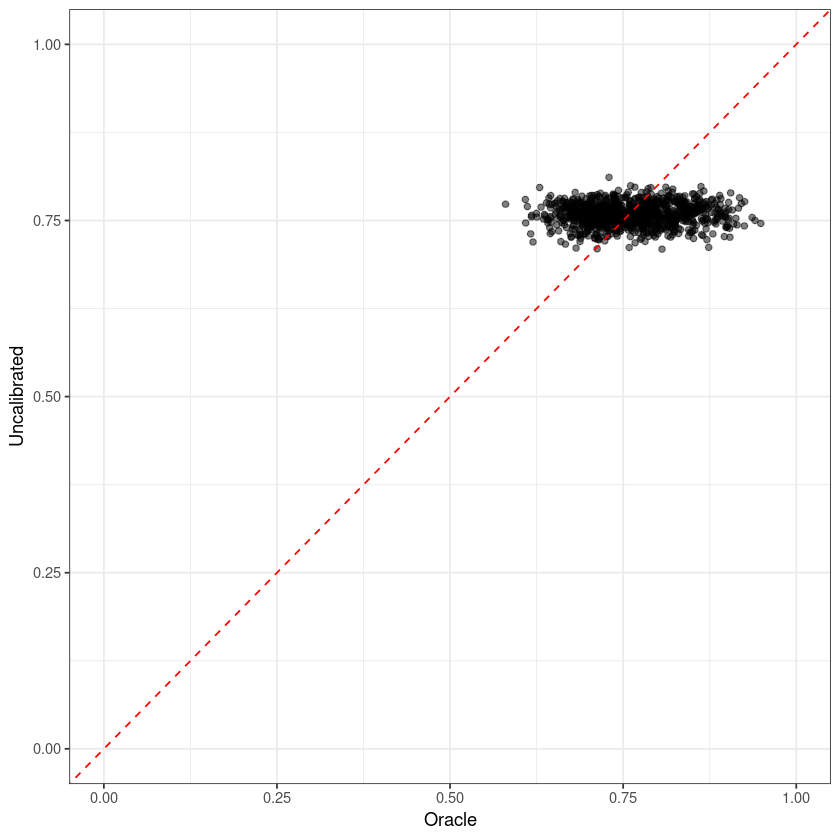

In [23]:
# Check calibration
tibble(Oracle=probs.oracle, Uncalibrated=probs.uncalibrated) |>
    ggplot(aes(x=Oracle, y=Uncalibrated)) +
    geom_point(alpha=0.5) +
    geom_abline(intercept=0, slope=1, color="red", linetype=2) +
    xlim(0,1) +
    ylim(0,1) +
    theme_bw()

In [24]:
# Load the progress package for progress tracking
library(progress)

#' Invert Survival Lower Predictive Bound (LPB)
#'
#' This function finds a lower bound on the survival probability at a given time horizon by 
#' inverting a Lower Predictive Bound (LPB) for survival time using binary search.
#'
#' @param data.test A data frame or matrix where each row represents a test instance.
#' @param compute_survival_lpb A function that computes the lower predictive bound (LPB) 
#'   for a given test instance and alpha level.
#' @param horizon A numeric value specifying the survival time threshold.
#' @param tol A numeric value specifying the tolerance for the binary search stopping criterion (default: `1e-2`).
#' @param max_iter An integer specifying the maximum number of binary search iterations (default: `5`).
#'
#' @return A numeric vector where each entry represents the estimated lower bound on survival 
#'   probability for the corresponding test instance.
#'
#' @details 
#' The function performs a binary search over the survival probability parameter `alpha` to 
#' find the smallest value such that the LPB is at least the given `horizon`. The survival 
#' probability lower bound is then computed as `1 - alpha`.
#'
invert_survival_lpb <- function(data.test, compute_survival_lpb, horizon, tol = 1e-2, max_iter = 10) {
    
    # Number of test instances
    n_test <- nrow(data.test)
    
    # Initialize vector to store survival probability lower bounds for each test row
    splb_results <- rep(NA, n_test)
    
    # Iterate over each row of data.test
    for (i in 1:n_test) {
        # Print progress inline (without a new line)
        cat(sprintf("\rProcessing test case %d/%d.", i, n_test))
        flush.console()  # Ensures immediate update in R console/Jupyter
        
        alpha_low <- 0
        alpha_high <- 1
        iter <- 0
        
        while ((alpha_high - alpha_low) > tol && iter < max_iter) {
            iter <- iter + 1
            alpha_mid <- (alpha_low + alpha_high) / 2
            
            # Compute lower predictive bound for this row
            lpb <- compute_survival_lpb(data.test[i, , drop = FALSE], alpha_mid)

            #cat(sprintf("Alpha: %.3f, LPB: %.2f\n", alpha_mid, lpb))
            
            # Update the search range
            if (lpb >= horizon) {
                alpha_high <- alpha_mid  # Try a smaller alpha
            } else {
                alpha_low <- alpha_mid   # Try a larger alpha
            }
        }
        
        # Store the smallest alpha found for this row
        splb_results[i] <- 1 - alpha_high
        
    }
    
    return(splb_results)
}

In [25]:
## Pre-computed alpha_hat values to speed up inversion of DR-COSARC with adaptive threshold

## List of percentiles for estimated survival distribution
num_a <- 200
probs <- seq(0.01, 0.99, length.out=num_a)

C.cal <- impute_drcosarc(data.cal, cens_model)
alpha_hat_values_gui <- compute_alpha_hat_Gui(data.cal, C.cal, surv_model, cens_model$model, num_a)

In [26]:
sample_transf_uniform <- function(values, n = 100, seed = NULL) {
    # Set seed for reproducibility
    if (!is.null(seed)) set.seed(seed)
    
    # Ensure n is not greater than available values
    n <- min(n, length(values))
    
    # Step 1: Sample `n` values uniformly from [0,1]
    uniform_samples <- runif(n, min = 0, max = 1)
       
    # Step 2: Find closest indices in the original vector
    sampled_indices <- sapply(uniform_samples, function(v) {
        which.min(abs(values - v))  # Get the index of the closest value in original vector
    })
    
    return(sampled_indices)  # Return indices
}

# Choose a small test set
n_test_small <- 20

probs.oracle <- generator$survival$predict(select(data.test, -time, -status), horizon)[[1]]
data_test_small <- data.test[sample_transf_uniform(probs.oracle,n_test_small),]

data_test_small <- data.test[sample(nrow(data.test), n_test_small), ]

In [27]:
# Goal: estimate P(T > horizon)
horizon <- 2.25

# Oracle survival probabilities
probs.oracle <- generator$survival$predict(select(data_test_small, -time, -status), horizon)[[1]]

# No calibration (trust the survival model's output)
probs.uncalibrated <- surv_model$predict(data_test_small, horizon)[[1]]

# CQR for observed time
cat(sprintf("Applying inversion with CQR method.\n"))
flush.console()
compute_slpb_cqr <- function(data.test, alpha) predict_CQR(data.test, surv_model, data.cal, alpha)
prob.cqr <- invert_survival_lpb(data_test_small, compute_slpb_cqr, horizon)

# CQR after KM de-censoring (Qi et al.) [This is a bit slow]
#cat(sprintf("\n\nApplying inversion with KM de-censoring method.\n"))
#flush.console()
#compute_slpb_kmd <- function(data.test, alpha) predict_decensoring(data.test, surv_model, km_fit, data.cal, alpha, R=10)
#prob.kmd <- invert_survival_lpb(data_test_small, compute_slpb_kmd, horizon)
prob.kmd <- NA

# DR-COSARC with fixed threshold (extending Candes et al.)
cat(sprintf("\n\nApplying inversion with DR-COSARC (fixed cutoffs) method.\n"))
flush.console()
compute_slpb_drcosarc_fix <- function(data.test, alpha) predict_drcosarc(data.test, surv_model, cens_model, data.cal, alpha, cutoffs="candes-fixed")
prob.drcosarc_fixed <- invert_survival_lpb(data_test_small, compute_slpb_drcosarc_fix, horizon)

# DR-COSARC with adaptive threshold (extending Gui et al.)
cat(sprintf("\n\nApplying inversion with DR-COSARC (adaptive cutoffs) method.\n"))
flush.console()
compute_slpb_drcosarc_ada <- function(data.test, alpha) predict_drcosarc(data.test, surv_model, cens_model, data.cal, alpha, cutoffs="adaptive", alpha_hat_values=alpha_hat_values_gui)
prob.drcosarc_ada <- invert_survival_lpb(data_test_small, compute_slpb_drcosarc_ada, horizon)

Applying inversion with CQR method.
Processing test case 20/20.

Applying inversion with DR-COSARC (fixed cutoffs) method.
Processing test case 20/20.

Applying inversion with DR-COSARC (adaptive cutoffs) method.
Processing test case 20/20.

Warning message:
“Removed 20 rows containing missing values or values outside the scale range
(`geom_point()`).”


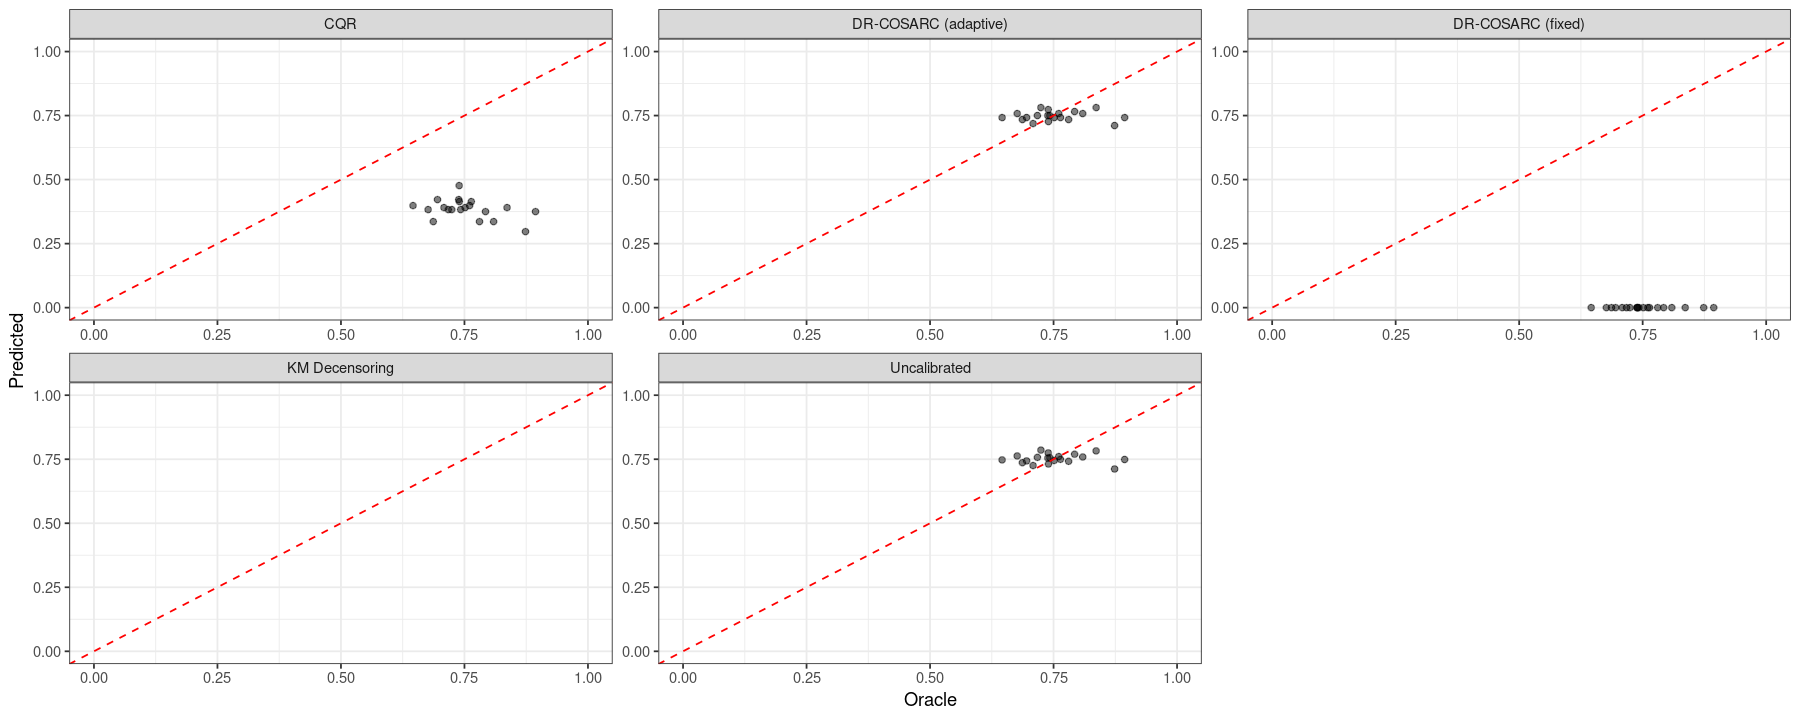

In [28]:
# Create a data frame with all probabilities
df <- tibble(
    Oracle = probs.oracle,
    Uncalibrated = probs.uncalibrated,
    CQR = prob.cqr,
    `KM Decensoring` = prob.kmd,
    `DR-COSARC (fixed)` = prob.drcosarc_fixed,
    `DR-COSARC (adaptive)` = prob.drcosarc_ada
)

# Convert to long format for faceting
df_long <- df |> pivot_longer(cols = -Oracle, names_to = "Model", values_to = "Predicted")

options(repr.plot.width=15, repr.plot.height=6)

# Create side-by-side scatter plots with facet_wrap()
ggplot(df_long, aes(x = Oracle, y = Predicted)) +
    geom_point(alpha = 0.5) +
    geom_abline(intercept = 0, slope = 1, color = "red", linetype = 2) +
    facet_wrap(~Model, scales = "free") +  # Side-by-side plots for each model
    xlim(0,1) +
    ylim(0,1) +
    theme_bw()


In [ ]:
hist(data.test$time)

In [ ]:
conformal_pvalue <- function(data.test, surv_model, cens_model, data.cal, horizon) {
    score.cal <- surv_model$predict(data.cal, horizon)[[1]]
    score.test <- surv_model$predict(data.test, horizon)[[1]]
    n <- nrow(data.cal)
    weights <- sapply(1:n, function(i) { 1/cens_model$predict(data.cal[i,], data.cal$time[i])$predictions} )
    T_tilde = data.cal$time
    event = data.cal$status
    den <- 1 + sum(sapply(1:n, function(i) {(T_tilde[i]<=horizon) * event[i] * weights[i]}) )
    pvals <- sapply(1:nrow(data.test), function(j) {
        num <- 1 + sum(sapply(1:n, function(i) {(T_tilde[i]<=horizon) * event[i] * weights[i] * (score.cal[i] >= score.test[j])}) )        
        return(pmin(1,num/den))
    })
    return(pvals)
}

                        
conformal_pvalue_cons <- function(data.test, surv_model, data.cal, horizon) {
    score.cal <- surv_model$predict(data.cal, horizon)[[1]]
    score.test <- surv_model$predict(data.test, horizon)[[1]]
    n <- nrow(data.cal)
    T_tilde = data.cal$time
    event = data.cal$status
    den <- 1 + sum(sapply(1:n, function(i) {(T_tilde[i]<=horizon) }) )
    pvals <- sapply(1:nrow(data.test), function(j) {
        num <- 1 + sum(sapply(1:n, function(i) {(T_tilde[i]<=horizon) * (score.cal[i] >= score.test[j])}) )
        return(pmin(1,num/den))
    })
    return(pvals)
}

horizon <- 2
#pvals <- conformal_pvalue(data.test, surv_model, cens_model$model, data.cal, horizon)
pvals <- conformal_pvalue(data.test, surv_model, censoring_generator, data.cal, horizon)
#pvals <- conformal_pvalue_cons(data.test, surv_model, data.cal, horizon)

In [ ]:
tibble(Null = data.test$time <= horizon, pvalue=pvals) |>
    ggplot(aes(x=pvalue)) +
    geom_histogram() +
    facet_wrap(Null~.) +
    theme_bw()

tibble(Null = data.test$time <= horizon, pvalue=pvals) |>
    ggplot(aes(x=pvalue, fill=Null)) +
    geom_histogram() +
    theme_bw()

In [ ]:
# Oracle survival probabilities
probs.oracle <- generator$survival$predict(select(data.test, -time, -status), horizon)[[1]]

# No calibration (trust the survival model's output)
probs.uncalibrated <- surv_model$predict(data.test, horizon)[[1]]

# Create a data frame with all probabilities
df <- tibble(
    Oracle = probs.oracle,
    Uncalibrated = probs.uncalibrated,
    `P-values (conservative)`= 1-pvals,
)

# Convert to long format for faceting
df_long <- df |> pivot_longer(cols = -Oracle, names_to = "Model", values_to = "Predicted")

options(repr.plot.width=15, repr.plot.height=6)

# Create side-by-side scatter plots with facet_wrap()
ggplot(df_long, aes(x = Oracle, y = Predicted)) +
    geom_point(alpha = 0.25) +
    geom_abline(intercept = 0, slope = 1, color = "red", linetype = 2) +
    facet_wrap(~Model, scales = "free") +  # Side-by-side plots for each model
    xlim(0,1) +
    ylim(0,1) +
    theme_bw()
